In [2]:
import sys
sys.path.append('../utils')
from PoNQ import PoNQ
import mesh_tools as mt
import torch
from pytorch3d.loss import chamfer_distance
from meshplot import plot
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import igl
import trimesh

In [7]:
GRID_N = 16
model_name = '../../data/tshirt.obj'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
def get_boundary_edge(f, normals):
    boundary_edges = igl.boundary_facets(f)
    is_f = f[None, :, :]==boundary_edges[:, 0, None, None]
    is_s = f[None, :, :]==boundary_edges[:, 1, None, None]
    is_face = np.logical_or(is_f, is_s).sum(-1)==2
    return boundary_edges, normals[is_face.argmax(-1)]

def uniform_edge_sampling(N, v, boundary_edges, boundary_normals):
    edge_length = np.sqrt(((v[boundary_edges[:, 1]]-v[boundary_edges[:, 0]])**2).sum(-1))
    selected_edges = np.random.choice(len(edge_length), N, p=edge_length/edge_length.sum())
    lambdas = np.random.rand(len(selected_edges))[:, None]
    sampled_points = v[boundary_edges[selected_edges][:, 1]]*lambdas + v[boundary_edges[selected_edges][:, 0]]*(1-lambdas)
    pseudo_normals = v[boundary_edges[selected_edges][:, 1]] - v[boundary_edges[selected_edges][:, 0]]
    pseudo_normals = np.cross(pseudo_normals, boundary_normals[selected_edges])
    pseudo_normals /= np.sqrt((pseudo_normals**2).sum(-1, keepdims=True))
    return sampled_points, boundary_normals[selected_edges], pseudo_normals

In [13]:
SURFACE_SAMPLING = 25000 * (GRID_N/16)**2
EDGE_SAMPLING = 2000 * (GRID_N/16)

v, f = mt.load_and_sample_shape(model_name, '', 0, 'NDC')
ref_mesh = trimesh.Trimesh(v,f)

total_area = igl.doublearea(v,f).sum()/2

samples, face_index = trimesh.sample.sample_surface_even(ref_mesh, int(SURFACE_SAMPLING*total_area))
samples = np.array(samples)
normals = np.array(ref_mesh.face_normals[face_index])
boundary_edges, boundary_normals = get_boundary_edge(f, igl.per_face_normals(v,f, np.ones(3)))

boundary_edge_length = np.sqrt(((v[boundary_edges[:, 1]]- v[boundary_edges[:, 0]])**2).sum(-1)).sum()
sampled_edges, sampled_edges_normals, pseudo_normals = uniform_edge_sampling(int(EDGE_SAMPLING*boundary_edge_length), v, boundary_edges, boundary_normals)


In [14]:
points = mt.mesh_grid(GRID_N, True)
V = PoNQ(points[mt.mask_relevant_voxels(GRID_N, samples)], device)

L=[]
global optimizer
optimizer = None

def reset_optimizer(lr=.01):
    global optimizer
    optimizer = torch.optim.Adam([V.points], lr)
reset_optimizer()

tensor_surface = torch.tensor(np.concatenate((samples, sampled_edges, sampled_edges)), dtype=torch.float32).to(device)
tensor_normals = torch.tensor(np.concatenate((normals, sampled_edges_normals, pseudo_normals)), dtype=torch.float32).to(device)

len(tensor_surface)

91883

### Further optim

In [15]:
def train_simple(V, repulsion_fac=0, sample_fac=1):
    optimizer.zero_grad()
    masks = torch.rand_like(tensor_surface[:, 0]) < sample_fac
    loss = chamfer_distance(tensor_surface[masks][None,:], V.points[None,:])[0].mean()
    if repulsion_fac>0:
        loss += -repulsion_fac*(V.distance_to_centroids(V.points,V.points).topk(2, 0, False).values[1].mean())
    x = loss.item()
    loss.backward()
    optimizer.step() 
    return x


100%|██████████| 300/300 [00:19<00:00, 15.38it/s]


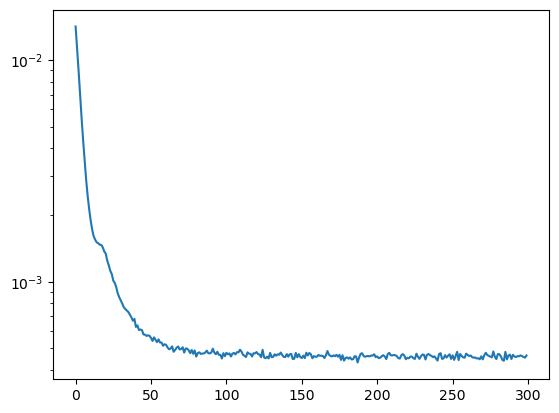

In [16]:
for i in tqdm(range(300)):
    L.append((train_simple(V, repulsion_fac=.1, sample_fac=.1)))
        # scheduler.step()
plt.plot(L)
plt.yscale('log')

### Simple plot

In [17]:
V.cluster_samples_quadrics_normals(tensor_surface, tensor_normals)

In [18]:
nvertices, in_triangle, in_scores = V.min_cut_surface(32, return_scores=True, open_treshold=.35)
mp = plot(nvertices, in_triangle)
mp.add_mesh(*V.quadric_ellipse_mesh())
# mt.export_obj(nvertices, in_triangle, 'tshirt')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0015825…

1